# Toyota Camry: три модели + важность признаков  
**Содержимое**:
1. Random Forest.
2. Gradient Boosting Regressor.
3. MLP Regressor.
4. Бар‑чарты важности для деревьев, пермутационная важность для MLP.
5. Таблица метрик + 5‑fold CV.

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

sns.set_context('talk')
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1️⃣ Загрузка
csv_path = '/content/drive/MyDrive/Интеллектуальный анализ данных /toyota_prices.csv'
df = pd.read_csv(csv_path, sep=';')
print(df.shape)

# 2️⃣ Feature engineering
CURRENT_YEAR = 2025
df['Age'] = CURRENT_YEAR - df['Year']
df['MileagePerYear'] = df['Odometer'] / df['Age'].replace(0, 0.1)
df['HpPerLiter'] = df['Horsepower'] / df['EngineVolume']
df.head()


(3362, 26)


,Generation,Year,Odometer,CarType,Color,EngineVolume,Horsepower,OilType,Box,Drive,...,MaxSpeed,AccelerationTo100,FuelGrade,TypeSupercharger,NumberCylinders,ValvesPerCylinder,Price,Age,MileagePerYear,HpPerLiter
0,VII (XV50),2012,153750,седан,чёрный,2.5,181,бензин,автоматическая,передний,...,210.0,9.0,аи-95,нет,4,4,1490000,13,11826.923077,72.400000
1,VIII (XV70),2021,30000,седан,чёрный,2.0,150,бензин,автоматическая,передний,...,210.0,11.0,аи-95,нет,4,4,3000000,4,7500.000000,75.000000
2,VII (XV50) Рестайлинг,2016,112483,седан,белый,2.5,181,бензин,автоматическая,передний,...,210.0,9.0,аи-95,нет,4,4,2395000,9,12498.111111,72.400000
3,VI (XV40),2009,263705,седан,чёрный,2.4,167,бензин,автоматическая,передний,...,205.0,9.3,аи-95,нет,4,4,900000,16,16481.562500,69.583333
4,VIII (XV70),2018,218000,седан,чёрный,3.5,249,бензин,автоматическая,передний,...,220.0,7.7,аи-95,нет,6,4,2599000,7,31142.857143,71.142857


In [ ]:
# 3️⃣ Подготовка
y = df['Price']
X = df.drop(columns=['Price'])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include=['object']).columns.to_list()

num_pipe = Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('sc', StandardScaler())])
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preproc = ColumnTransformer([('num', num_pipe, num_cols),
                             ('cat', cat_pipe, cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
from math import sqrt

# 4️⃣ Обучение моделей
models = {

    'RandomForest': RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),

    'GradientBoosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42),

    'MLP': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, learning_rate_init=0.001, early_stopping=True, random_state=42)

}

trained, table = {}, []

for name, est in models.items():

    pipe = Pipeline([('prep', preproc), ('est', est)])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))

    mae = mean_absolute_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)

    cv = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

    table.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'CV_RMSE': -cv.mean(), 'CV_STD': cv.std()})

    trained[name] = pipe

(pd.DataFrame(table)

    .set_index('Model')

    .style.format({'RMSE':'{:.0f}','MAE':'{:.0f}','R2':'{:.3f}','CV_RMSE':'{:.0f}','CV_STD':'{:.0f}'}))



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,RMSE,MAE,R2,CV_RMSE,CV_STD
Model,,,,,
RandomForest,168675,59380,0.978,171182,181090
GradientBoosting,172798,78508,0.977,198396,157701
MLP,414761,301221,0.869,456330,108902


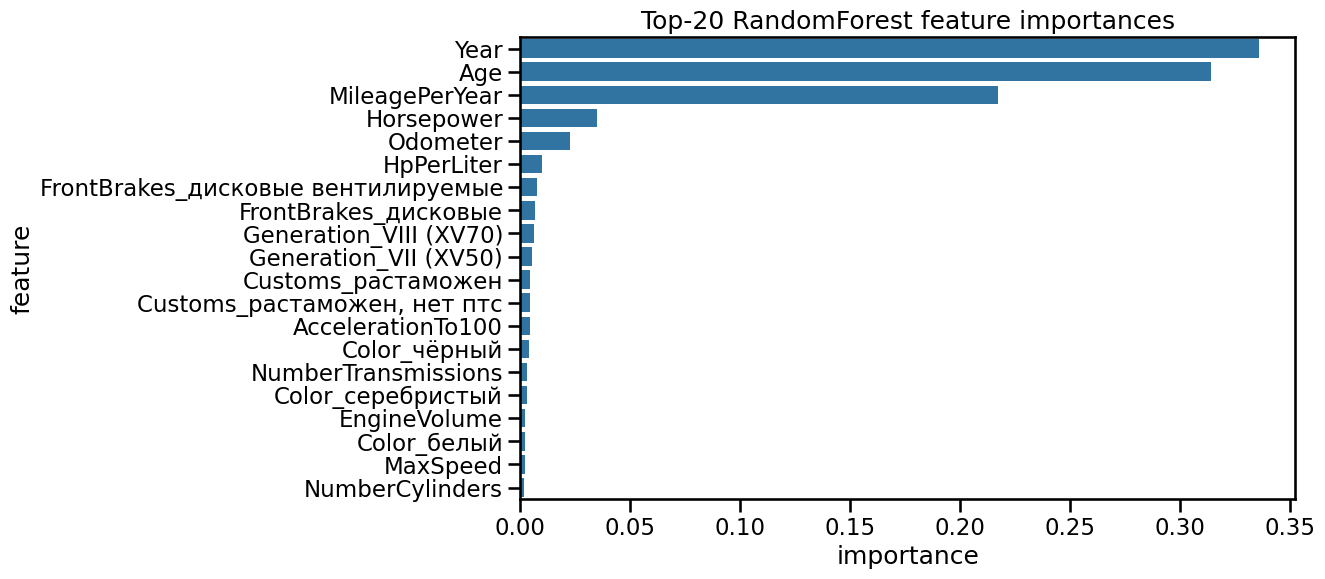

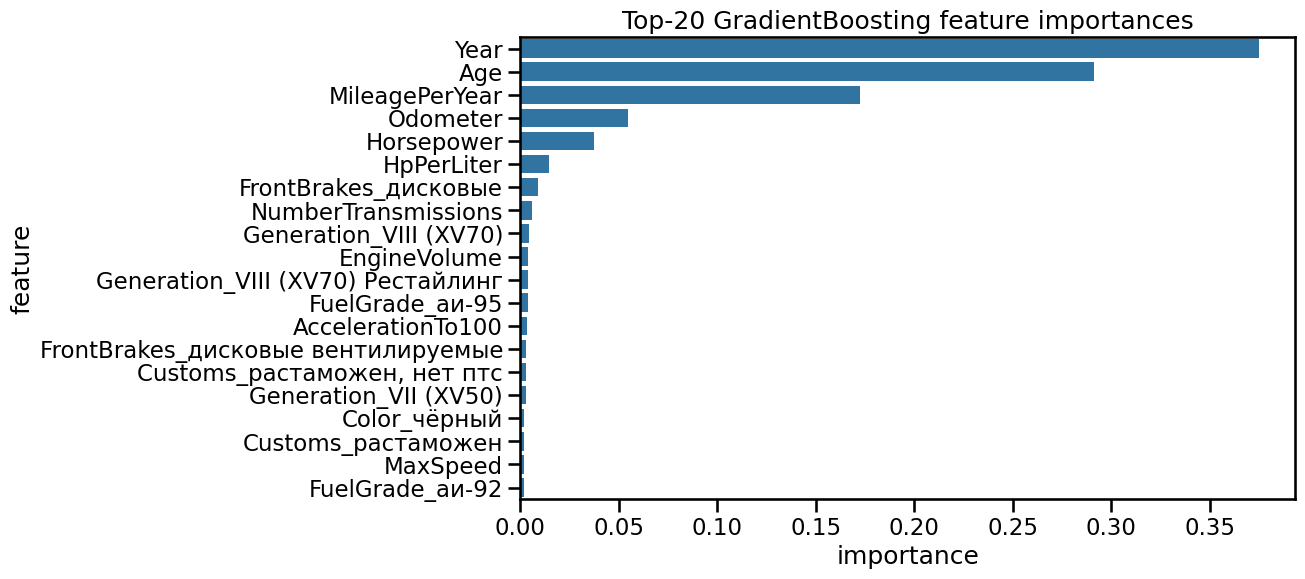

In [ ]:
# 5️⃣ Важность признаков для деревьев
ohe = trained['RandomForest'].named_steps['prep'].named_transformers_['cat'].named_steps['ohe']

feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))



def plot_imp(model_key):

    imp = trained[model_key].named_steps['est'].feature_importances_

    imp_df = (pd.DataFrame({'feature': feature_names, 'importance': imp})

              .sort_values('importance', ascending=False).head(20))

    plt.figure(figsize=(10,6))

    sns.barplot(data=imp_df, x='importance', y='feature')

    plt.title(f'Top‑20 {model_key} feature importances')

    plt.show()



plot_imp('RandomForest')

plot_imp('GradientBoosting')



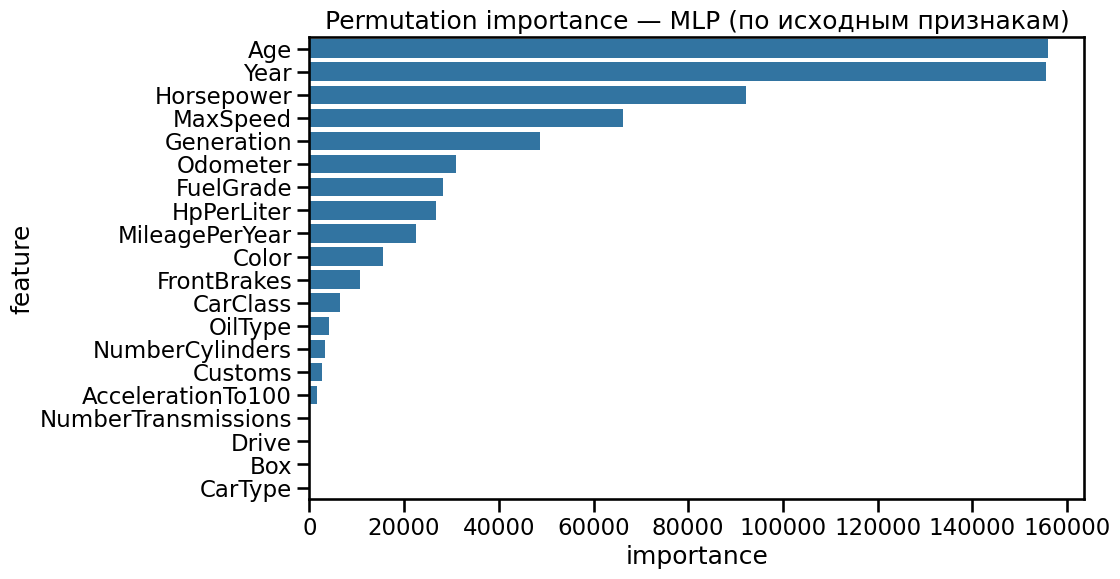

In [ ]:
# 6️⃣ Пермутационная важность для MLP

result = permutation_importance(
    trained['MLP'],          # Pipeline
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

feature_names_perm = X.columns          # 26 исходных признаков
perm_df = (pd.DataFrame({
                'feature': feature_names_perm,
                'importance': result.importances_mean})
           .sort_values('importance', ascending=False)
           .head(20))

plt.figure(figsize=(10,6))
sns.barplot(data=perm_df, x='importance', y='feature')
plt.title('Permutation importance — MLP (по исходным признакам)')
plt.show()